# Influence of duplicates on model performance

In [1]:
# Imports
import os

import numpy as np
import pandas as pd
import plotnine as pn

# Set directory
os.chdir('path_to_your_dir')


/var/folders/h1/5mmv2z5n7xz9rwls3g_gr7580000gn/T/ipykernel_3038/3609553964.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Get performance metrics
def get_values(tcrex,epitope,column):
    return tcrex[tcrex['epitope']==epitope][column].tolist()[0]

tcrex = pd.read_csv('./data/parsed/tcrex_models.csv')


In [3]:
# Read in all epitope-specific TCRs parsed by TCRex
# df may not contain , in epitopes: every tcr-epitope should take one row 
df = pd.read_csv('./data/final/all_tcrs.tsv')
df 

,v_call,junction_aa,j_call,epitope
0,TRBV07-06,CASSLARGVLMNTEAFF,TRBJ01-01,TVYDPLQPELDSFK
1,TRBV10-02,CASSKGSTEAFF,TRBJ01-01,TVYDPLQPELDSFK
2,TRBV27,CASSLMGGSSYEQYF,TRBJ02-07,TVYDPLQPELDSFK
3,TRBV07-02,CASSLVLASYEQYF,TRBJ02-07,TVYDPLQPELDSFK
4,TRBV04-01,CASSLMAGPGNIQYF,TRBJ02-04,TVYDPLQPELDSFK
...,...,...,...,...
44192,TRBV04-02,CASSQDSGQIDTGELFF,TRBJ02-02,ALSKGVHFV
44193,TRBV27,CASSLSGGWAGGLEQYF,TRBJ02-07,ALSKGVHFV
44194,TRBV27,CASSLSGTYYEQYF,TRBJ02-07,ALSKGVHFV
44195,TRBV27,CASSISVYSPLHF,TRBJ01-06,ALSKGVHFV


In [4]:
epitopes = set(df['epitope'].tolist())

In [5]:
dropped = pd.DataFrame()

# number of distances per auc
for epitope in epitopes:
    
    # Read in all positive training data for the epitope
    data = df[df['epitope']==epitope]
    
    # Calculate nr of duplicates
    size1 = data.shape[0]
    data = data.drop_duplicates(subset=['junction_aa'])
    size2 = data.shape[0]
    drops = size1-size2
    duplicates = pd.DataFrame({'epitope':epitope,'dropped':[drops]})

    dropped = pd.concat([dropped,duplicates])    

In [6]:
# Add performance metrics to df
dropped['roc'] = dropped['epitope'].apply(lambda x: get_values(tcrex,x,'roc_auc'))
dropped['Average precision'] = dropped['epitope'].apply(lambda x: get_values(tcrex,x,'average_precision'))
dropped['accuracy'] = dropped['epitope'].apply(lambda x: get_values(tcrex,x,'accuracy'))
dropped['size'] = dropped['epitope'].apply(lambda x: get_values(tcrex,x,'nr_target_sequences'))
dropped['%dropped'] = (dropped['dropped']/dropped['size'])*100
dropped.sort_values(by='%dropped', ascending=False)

,epitope,dropped,roc,Average precision,accuracy,size,%dropped
0,RPRGEVRFL,18,0.917155,0.835172,0.769231,63,28.571429
0,ARMILMTHF,16,0.858704,0.691203,0.738462,66,24.242424
0,TPQDLNTML,38,0.939053,0.867880,0.812500,159,23.899371
0,QYDPVAALF,7,0.820934,0.598020,0.700000,41,17.073171
0,IIKDYGKQM,9,0.946380,0.837080,0.809091,54,16.666667
...,...,...,...,...,...,...,...
0,IPSINVHHY,0,0.836782,0.660894,0.704706,85,0.000000
0,ILIEGIFFV,0,0.815736,0.553536,0.631370,111,0.000000
0,RFYKTLRAEQASQ,0,0.994002,0.958072,0.901667,210,0.000000
0,TSNQVAVLY,0,0.690533,0.251124,0.515867,62,0.000000


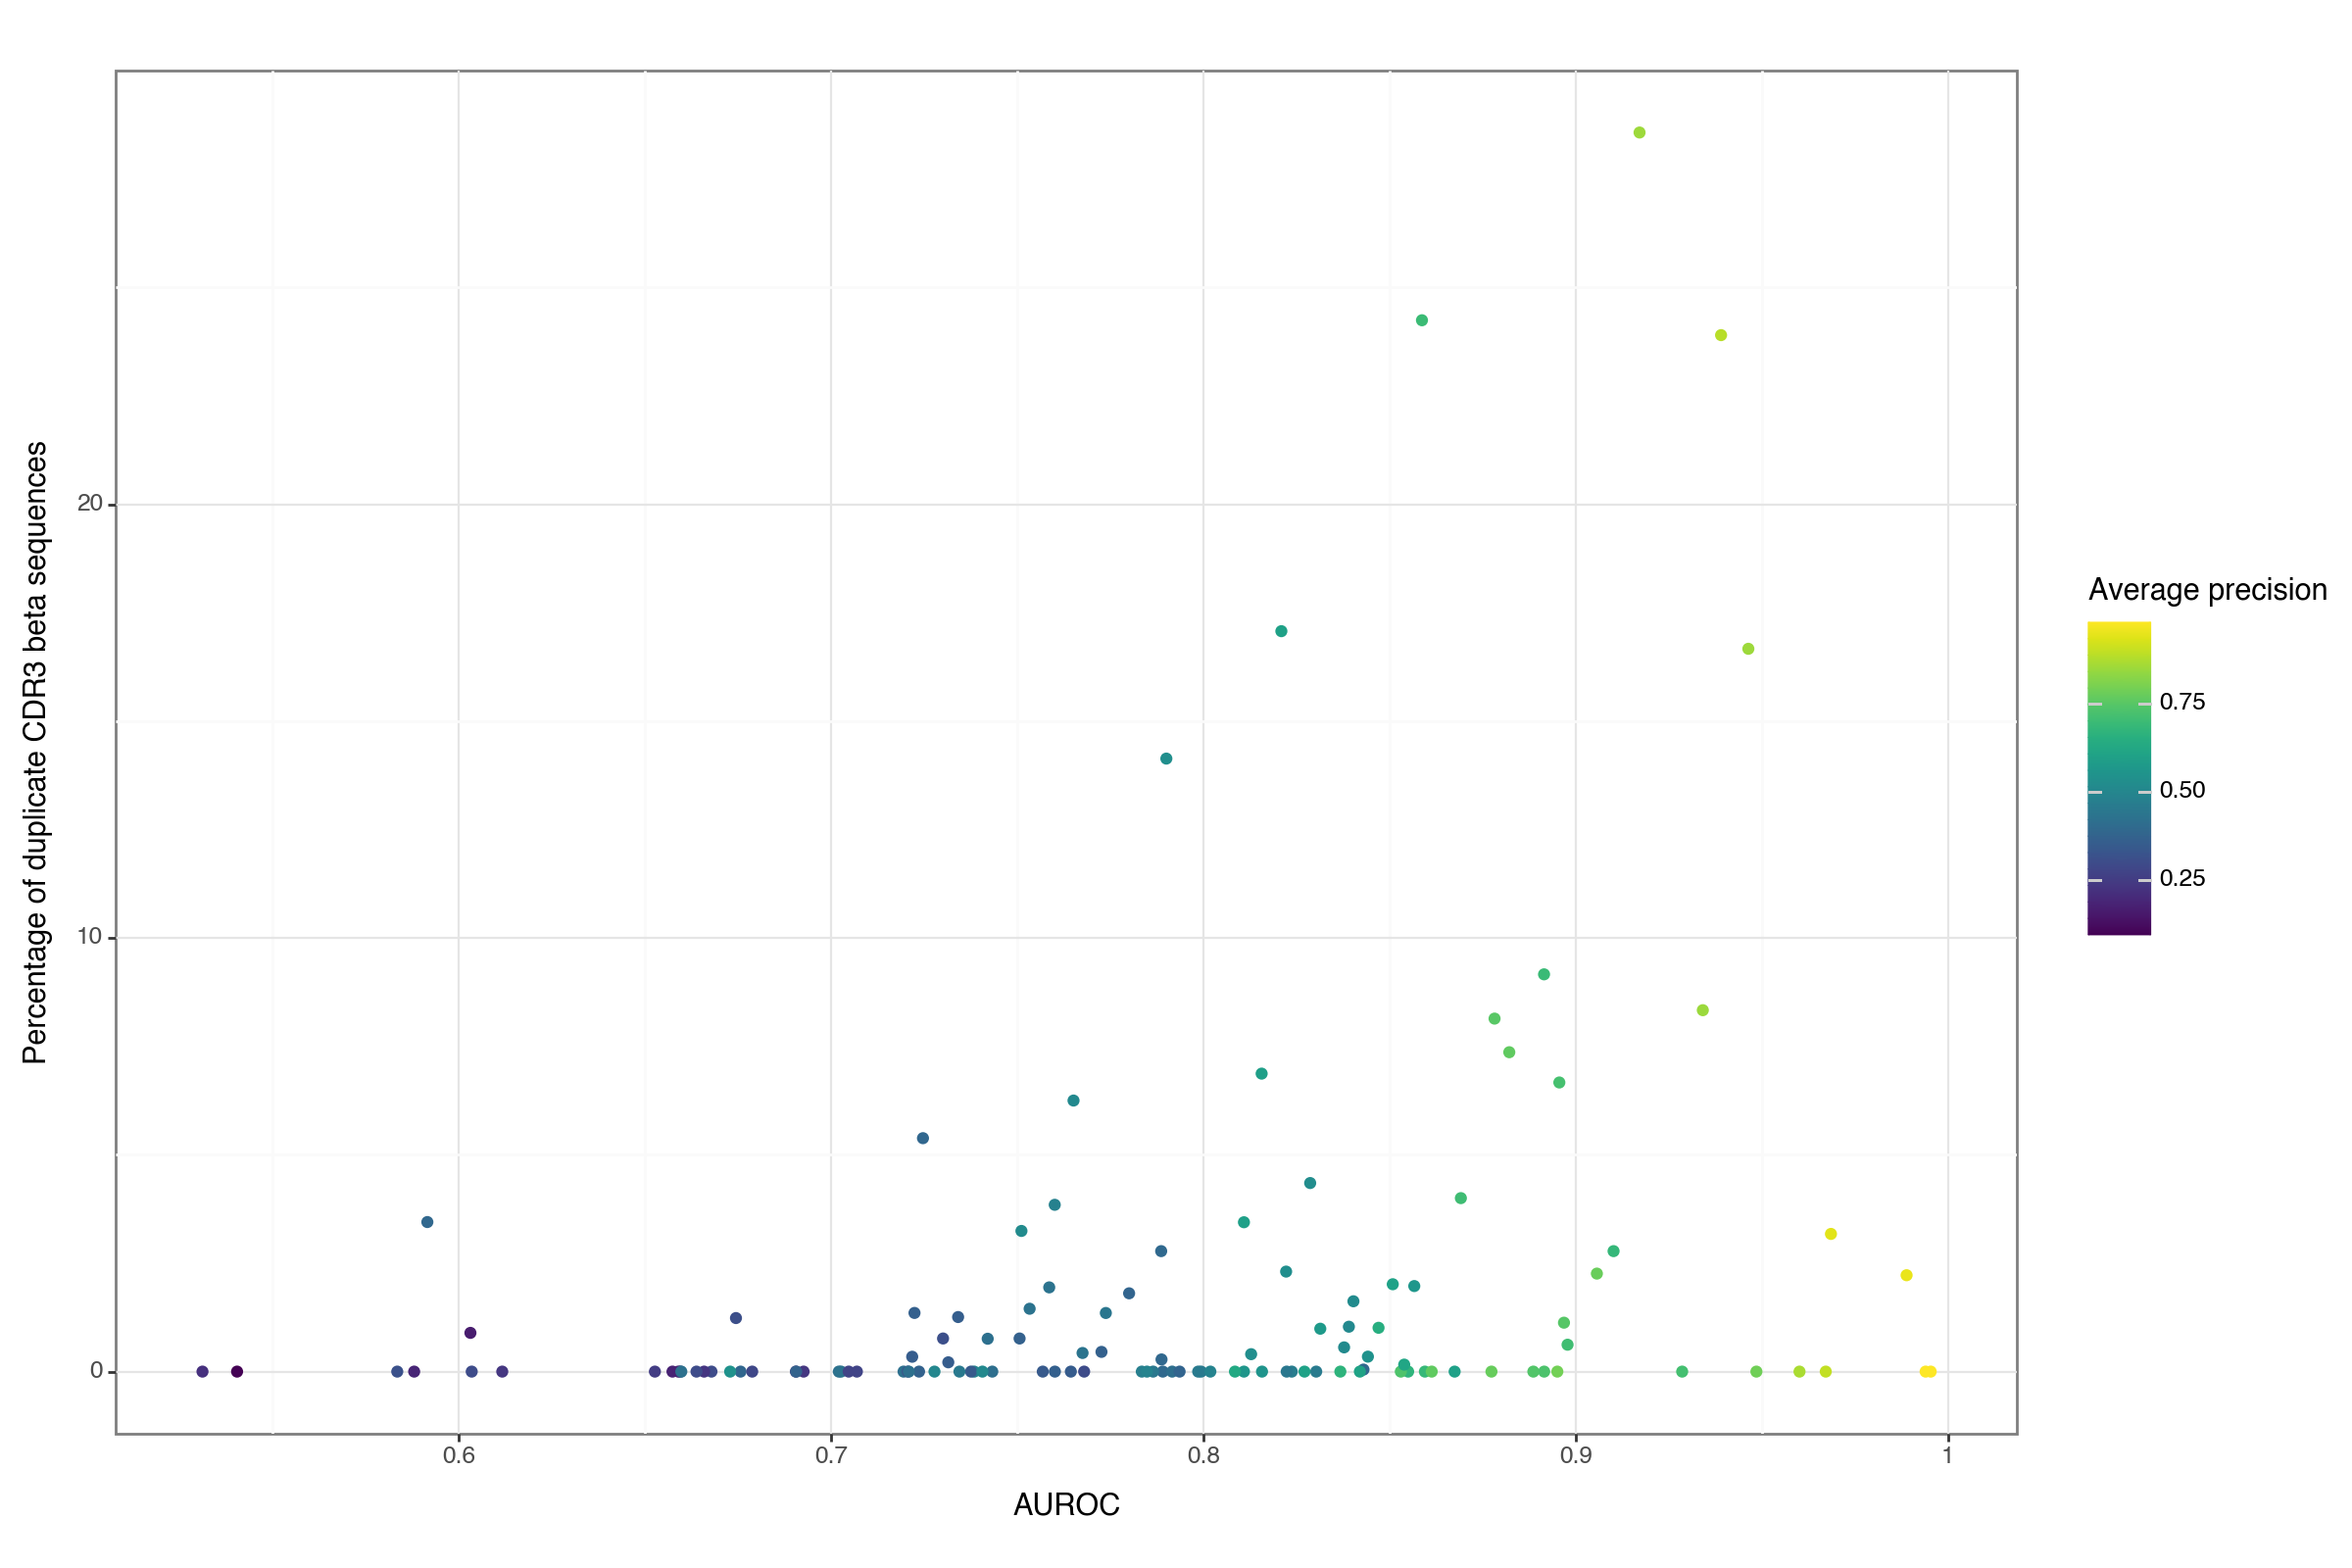

In [7]:
fig = (pn.ggplot(dropped, pn.aes('roc','%dropped',colour='Average precision',label='epitope'))  + 
 pn.geom_point() +
 #pn.geom_text(angle=90,size=5,color='black')+
 pn.theme_bw() +
 pn.labels.ylab('Percentage of duplicate CDR3 beta sequences') +
 pn.labels.xlab('AUROC') +
 pn.theme(figure_size=(12, 8))).draw(show=True)


fig.savefig('./figures/duplicates/duplicates.pdf', dpi=300)